# Fokker-Planck Equation

### Matrix initialization refactor

Currently, the diffusion matrices are initialized using a native python list comprehension. This is inefficient from a computational perspective, and in this notebook we attempt to improve upon this process by translating the initialization into lower-level python libraries (`numpy`).

In [32]:
# First import the FPE library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from FPE.Integrator import FPE_Integrator_1D
sns.set(style="darkgrid", palette="hls")

D = 1.0
dt = 0.01
dx = 0.2
x_array = np.arange(0, 1, dx)

# Firsty, start with open boundaries os that there is no influence from the BCs
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='open')

In [2]:
fpe.AMat

array([[ 1.25 , -0.125,  0.   ,  0.   ,  0.   ],
       [-0.125,  1.25 , -0.125,  0.   ,  0.   ],
       [ 0.   , -0.125,  1.25 , -0.125,  0.   ],
       [ 0.   ,  0.   , -0.125,  1.25 , -0.125],
       [ 0.   ,  0.   ,  0.   , -0.125,  1.25 ]])

Simply, this ia a tridiagonal matrix, with diagonal terms given by 

$$ A_{ii} = 1 + 2\alpha*\beta $$

where $\alpha = D \Delta t / (\Delta x)^2$ is determined by input parameters, and $\beta \in [0, 1]$ is the splitting fraction between explicit (0) and implicit (1) schemes (which defaults to the Crank-Nicolson avlue of 1/2).

the off diagonal terms are 

$$ A_{i, i\pm 1} = -\alpha\beta $$

So, we can initialize this matrix by simply adding together three diagonal matrices, generate using `numpy`


In [7]:
alpha = D * dt / (dx * dx)
beta = 0.5

AMat_alt = (
    np.diag(1 + 2 * alpha * beta * np.ones(len(x_array)))
    + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=1)
    + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=-1)
)

AMat_alt

array([[ 1.25 , -0.125,  0.   ,  0.   ,  0.   ],
       [-0.125,  1.25 , -0.125,  0.   ,  0.   ],
       [ 0.   , -0.125,  1.25 , -0.125,  0.   ],
       [ 0.   ,  0.   , -0.125,  1.25 , -0.125],
       [ 0.   ,  0.   ,  0.   , -0.125,  1.25 ]])

In [18]:
# Now, we can look at timing the initialization on the list comprehension and numpy 'version'
# in the open boundary conditions, for various grid sizes

dx = 0.01
x_array = np.arange(0, 1, dx)
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='open')

def initDiffusionMatrix_alt(alpha, beta, x_array):
    _ = (
        np.diag(1 + 2 * alpha * beta * np.ones(len(x_array)))
        + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=1)
        + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=-1)
    )

In [19]:
%timeit fpe.initDiffusionMatrix()

3.82 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
res = %timeit -o initDiffusionMatrix_alt(alpha, beta, x_array)

35.9 µs ± 684 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
# Now lets look at this scaling with grid dimension
N = [2 ** i * 5 for i in range(10)]

time_legacy = []
err_legacy = []
time_alt = []
err_alt = []

for n in N:
    x_array = np.linspace(0, 1, n)
    dx = x_array[1] - x_array[0]
    alpha = D * dt / (dx * dx)
    fpe = FPE_Integrator_1D(D, dt, dx, x_array)
    res_leg = %timeit -o fpe.initDiffusionMatrix()
    res_alt = %timeit -o initDiffusionMatrix_alt(alpha, beta, x_array)

    time_legacy.append(res_leg.average)
    time_alt.append(res_alt.average)

    err_legacy.append(res_leg.stdev)
    err_alt.append(res_alt.stdev)


42.4 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
17.5 µs ± 126 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
97.6 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
18.1 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
239 µs ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.7 µs ± 81 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
The slowest run took 4.00 times longer than the fastest. This could mean that an intermediate result is being cached.
970 µs ± 698 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.5 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.44 ms ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.9 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.07 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
56.7 µs ± 482 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each

Text(0, 0.5, 'Initialization time (seconds)')

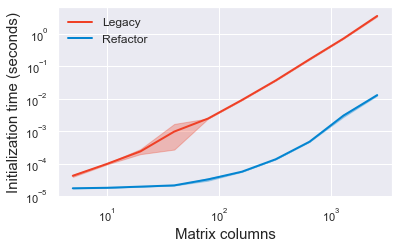

In [35]:
# And now we can plot the timed results to investigate
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.fill_between(N, np.array(time_legacy) + np.array(err_legacy), np.array(time_legacy) - np.array(err_legacy), color=sns.xkcd_rgb["tomato"], alpha=0.3)
ax.fill_between(N, np.array(time_alt) + np.array(err_alt), np.array(time_alt) - np.array(err_alt), color=sns.xkcd_rgb["cerulean"], alpha=0.3)

ax.plot(N, time_legacy, linewidth=2.0, color=sns.xkcd_rgb["tomato"], label="Legacy")
ax.plot(N, time_alt, linewidth=2.0, color=sns.xkcd_rgb["cerulean"], label="Refactor")

ax.legend(fontsize=12, frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"Matrix columns", fontsize=15)
ax.set_ylabel(r"Initialization time (seconds)", fontsize=15)



So, here we can see that there is a speedup of over two orders of magnitude asymptotically with the numpy-based initialization. This is largely expected, as list comprehensions are pure python in their execution (and further act on the most inefficient aspects of python at that), while the `numpy` based initialization is largely working off of the `C`-based backend of the highly optimized `numpy` library.

In the background, I have updated the implementations of the matrix initialization in the integrator code, so the final step will be to check that the two routines generate the same matrices for all boundary conditions, and then delete the depricated code, and submit the modifications to the master branch